# Amazon stock price prediction using Machine learning with Time Series analysis

It is very difficult to predict the way stock market behaves. One good way to look at it is analyzing the historical data associated and predict future trends. But there are so many other factors that impact a stock price - market sentiments, boards financial decisions, geographical locations and nowadays social media interaction via Twitter etc. 

This means that there are no consistent patterns in the data that allow you to model stock prices over time near-perfectly. 
A very famous economist from Princeton University, Burton Malkiel, once mentioned in his book "A Random Walk Down Wall Street," that if the market is truly efficient and a share price reflects all factors immediately as soon as they're made public, a blindfolded monkey throwing darts at a newspaper stock listing should do as well as any investment professional.

Hpwever, lets not loose our hopes and concentrate on what machine learning can do here to model the data, so that the predictions we make correlate with the actual behavior of the data. 

# Understanding the Problem Statement

We’ll dive into the implementation part of this article soon, but first it’s important to establish what we’re aiming to solve. Broadly, stock market analysis is divided into two parts – Fundamental Analysis and Technical Analysis.

Fundamental Analysis involves analyzing the company’s future profitability on the basis of its current business environment and financial performance.
Technical Analysis, on the other hand, includes reading the charts and using statistical figures to identify the trends in the stock market.
As you might have guessed, our focus will be on the technical analysis part. We’ll be using stock data from macrotrends.com to dive in!

We will first load the dataset, see its structure and define the target variable for the problem:

In [1]:
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('MacroTrends_Data_Download_AMZN.csv')

#print the head
df.head()

,date,open,high,low,close,volume
0,5/16/1997,1.8650,1.9792,1.7083,1.7292,14700000
1,5/19/1997,1.7083,1.7708,1.6250,1.7083,6106800
2,5/20/1997,1.7292,1.7500,1.6358,1.6358,5467200
3,5/21/1997,1.6042,1.6458,1.3750,1.4275,18853200
4,5/22/1997,1.4375,1.4483,1.3125,1.3958,11776800


In [2]:
# Print the tail of df
print(df.tail())

            date     open     high      low    close   volume
5401  10/31/2018  1569.99  1623.91  1565.09  1598.01  9390211
5402   11/1/2018  1623.53  1670.45  1598.44  1665.53  8135539
5403   11/2/2018  1678.59  1697.44  1651.83  1665.53  6955548
5404   11/5/2018  1657.57  1658.09  1596.36  1627.80  5624727
5405   11/6/2018  1618.35  1665.00  1614.55  1642.81  4176813


In [3]:
# Print the shape of df
print(df.shape)

(5406, 6)


In [4]:
# Print the columns of df
print(df.columns)

Index(['date', 'open', 'high', 'low', 'close', 'volume'], dtype='object')


There are multiple variables in the dataset – date, open, high, low, close, and volume.

The columns Open and Close represent the starting and final price at which the stock is traded on a particular day.
High, Low and Last represent the maximum, minimum, and last price of the share for the day.
Total Trade Quantity is the number of shares bought or sold in the day and Turnover (Lacs) is the turnover of the particular company on a given date.
# Now lets do some data wrangling on the data for some additional observations on the data

In [5]:
len(df)

5406

In [6]:
#check for duplicate data on date values
df['date'].nunique()

5406

In [7]:
# Find any NULL values
df.isnull().values.any()

False

### Seems like the data available does not have any NULL values and duplicates. We will see if we find any other data issue while working on it further

The profit or loss calculation is usually determined by the closing price of a stock for the day, hence we will consider the closing price as the target variable. Let’s plot the target variable to understand how it’s shaping up in our data:

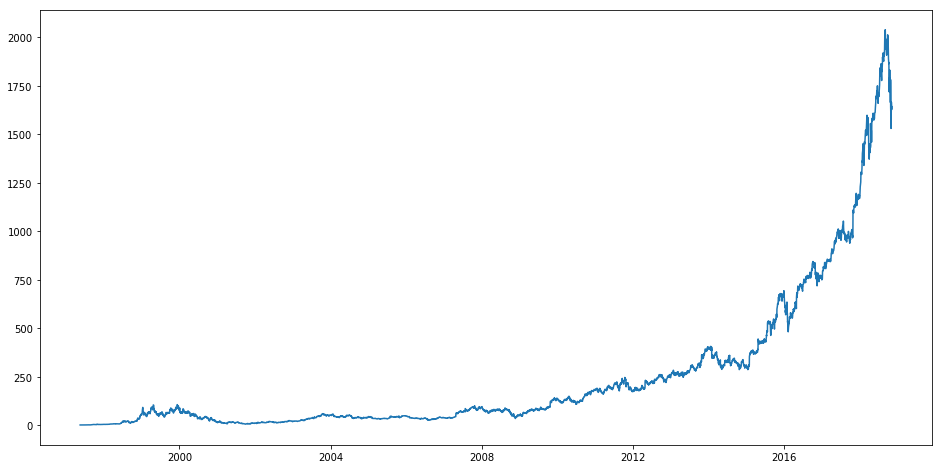

In [8]:
#setting index as date
df['date'] = pd.to_datetime(df.date,format='%m/%d/%Y')
df.index = df['date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['close'], label='Close Price history')

Wow, we a steep incline in the Amazon price after 2016. Some of you would be rich if you were holding the stock since prior 2016. :)
### Anyways, in the next sections, we are going to explore these variables and use different techniques to predict the daily closing stock prices.

# Moving Average

## Introduction

‘Average’ is easily one of the most common things we use in our day-to-day lives. For instance, calculating the average marks to determine overall performance, or finding the average temperature of the past few days to get an idea about today’s temperature – these all are routine tasks we do on a regular basis. So this is a good starting point to use on our dataset for making predictions.

The predicted closing price for each day will be the average of a set of previously observed values. Instead of using the simple average, we will be using the moving average technique which uses the latest set of values for each prediction. In other words, for each subsequent step, the predicted values are taken into consideration while removing the oldest observed value from the set. Here is a simple figure that will help you understand this with more clarity.

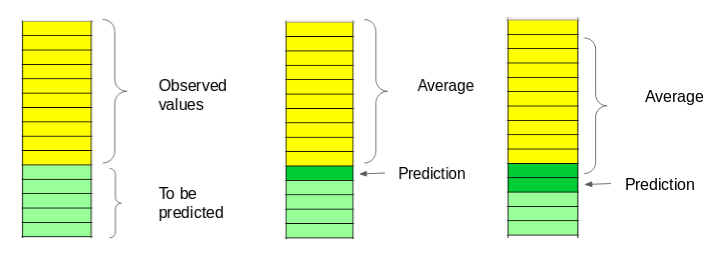

In [9]:
from IPython.display import Image
Image(filename=r"C:/Users/anshu/Downloads/moving_avg.jpeg")

We will implement this technique on our dataset. The first step is to create a dataframe that contains only the date and close price columns, then split it into train and validation sets to verify our predictions.

In [10]:
#creating dataframe with date and the target variable
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['date', 'close'])

for i in range(0,len(data)):
     new_data['date'][i] = data['date'][i]
     new_data['close'][i] = data['close'][i]

In [11]:
print(new_data.head())

                  date   close
0  1997-05-16 00:00:00  1.7292
1  1997-05-19 00:00:00  1.7083
2  1997-05-20 00:00:00  1.6358
3  1997-05-21 00:00:00  1.4275
4  1997-05-22 00:00:00  1.3958


In [12]:
new_data.shape

(5406, 2)

In [13]:
#new_data[4898:]['date'].min()
#splitting into train and validation. Here we are taking last two years of data as test and prior to that as train
train = new_data[:4898]
valid = new_data[4898:]

In [14]:
new_data.shape, train.shape, valid.shape

((5406, 2), (4898, 2), (508, 2))

In [15]:
train['date'].min(), train['date'].max(), valid['date'].min(), valid['date'].max()

(Timestamp('1997-05-16 00:00:00'),
 Timestamp('2016-10-31 00:00:00'),
 Timestamp('2016-11-01 00:00:00'),
 Timestamp('2018-11-06 00:00:00'))

The next step is to create predictions for the validation set and check the RMSE using the actual values.

In [16]:
#make predictions
preds = []
for i in range(0,508):
    a = train['close'][len(train)-508+i:].sum() + sum(preds)
    b = a/508
    preds.append(b)

# Results

In [17]:
#calculate rmse
rms=np.sqrt(np.mean(np.power((np.array(valid['close'])-preds),2)))
rms

717.9882259690223

Just checking the RMSE does not help us in understanding how the model performed. Let’s visualize this to get a more intuitive understanding. So here is a plot of the predicted values along with the actual values.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


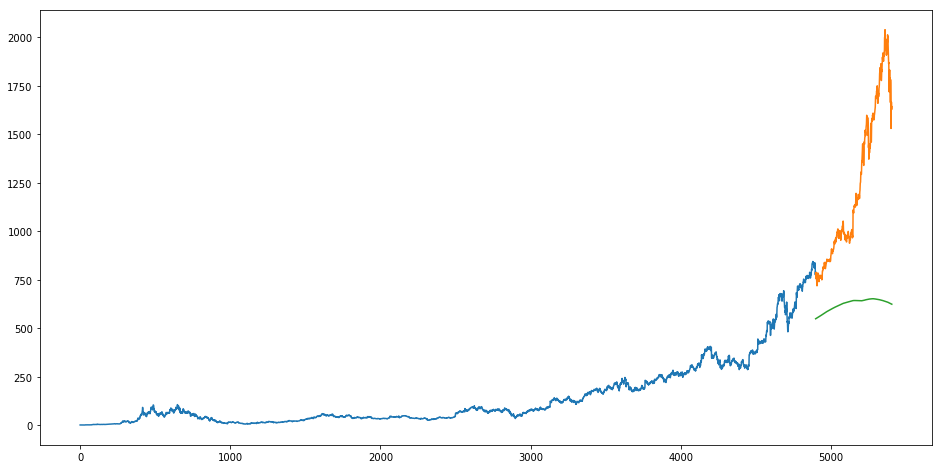

In [18]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.figure(figsize=(16,8))
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])

# Inference

The RMSE value is close to 717 and the results are not very promising (as you can gather from the plot). The predicted values are of the same range as the observed values in the train set (there is an increasing trend initially and then a slow decrease).

# Linear Regression

## Introduction

The most basic machine learning algorithm that can be implemented on this data is linear regression. The linear regression model returns an equation that determines the relationship between the independent variables and the dependent variable.
For our problem statement, we do not have a set of independent variables. We have only the dates instead. Let us use the date column to extract features like – day, month, year,  mon/fri etc. and then fit a linear regression model.

## Implementation

We will first sort the dataset in ascending order and then create a separate dataset so that any new feature created does not affect the original data.

In [19]:
#setting index as date values
df['date'] = pd.to_datetime(df.date,format='%m/%d/%y')
df.index = df['date']

#sorting
data = df.sort_index(ascending=True, axis=0)

#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['date', 'close'])

for i in range(0,len(data)):
    new_data['date'][i] = data['date'][i]
    new_data['close'][i] = data['close'][i]

In [20]:
new_data['Year']=new_data['date'].dt.year
new_data['Month']=new_data['date'].dt.month
new_data['Week']=new_data['date'].dt.week
new_data['Dayofweek']=new_data['date'].dt.dayofweek
new_data['Dayofyear']=new_data['date'].dt.dayofyear
new_data['Is_month_end']=new_data['date'].dt.is_month_end
new_data['Is_month_start']=new_data['date'].dt.is_month_start
new_data['Is_quarter_end']=new_data['date'].dt.is_quarter_end
new_data['Is_quarter_start']=new_data['date'].dt.is_quarter_start
new_data['Is_year_end']=new_data['date'].dt.is_year_end
new_data['Is_year_start']=new_data['date'].dt.is_year_start

#‘Year’, ‘Month’, ‘Week’, ‘Day’, ‘Dayofweek’, ‘Dayofyear’, ‘Is_month_end’, ‘Is_month_start’, 
#‘Is_quarter_end’, ‘Is_quarter_start’,  ‘Is_year_end’, and  ‘Is_year_start’
#create features
#import fastai as fs
#from fastai.structured import add_datepart
#add_datepart(new_data, 'date')
#new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp
new_data = new_data.drop('date',axis=1)

In [21]:
new_data.head()

,close,Year,Month,Week,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,1.7292,1997,5,20,4,136,False,False,False,False,False,False
1,1.7083,1997,5,21,0,139,False,False,False,False,False,False
2,1.6358,1997,5,21,1,140,False,False,False,False,False,False
3,1.4275,1997,5,21,2,141,False,False,False,False,False,False
4,1.3958,1997,5,21,3,142,False,False,False,False,False,False


In [22]:
#split into train and validation
train = new_data[:4898]
valid = new_data[4898:]

x_train = train.drop('close', axis=1)
y_train = train['close']
x_valid = valid.drop('close', axis=1)
y_valid = valid['close']

#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [23]:
#make predictions and find the rmse
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

912.0623018675368

The RMSE value is higher than the previous technique, which clearly shows that linear regression has performed poorly. Let’s look at the plot and understand why linear regression has not done well:

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


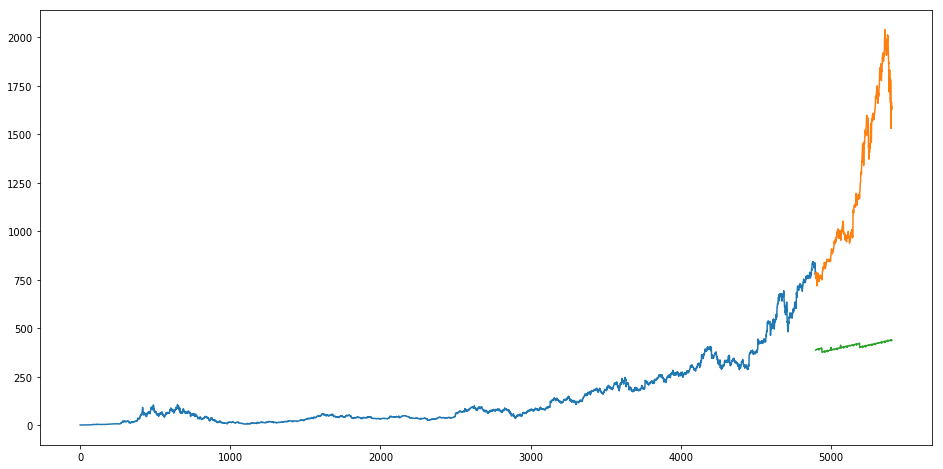

In [24]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds

valid.index = new_data[4898:].index
train.index = new_data[:4898].index

plt.figure(figsize=(16,8))
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])

## Inference

Linear regression is a simple technique and quite easy to interpret, but there are a few obvious disadvantages. One problem in using regression algorithms is that the model overfits to the date and month column. Instead of taking into account the previous values from the point of prediction, the model will consider the value from the same date a month ago, or the same date/month a year ago.

# k-Nearest Neighbours

## Introduction

Based on the independent variables, kNN finds the similarity between new data points and old data points. 

## Implementation

In [25]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

Using the same train and validation set from the last section:

In [26]:
#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)

# Results

In [27]:
#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

957.1290245193059

There is not a huge difference in the RMSE value, but a plot for the predicted and actual values should provide a more clear understanding.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


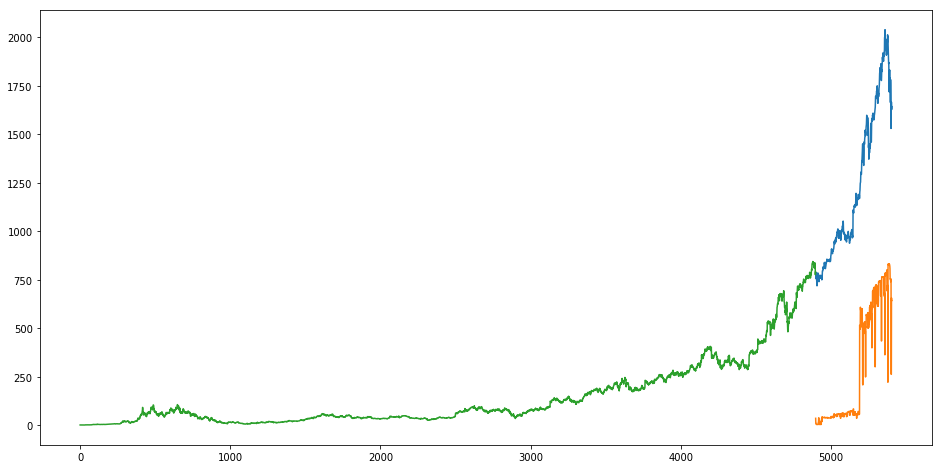

In [28]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.figure(figsize=(16,8))
plt.plot(valid[['close', 'Predictions']])
plt.plot(train['close'])

# Inference

The RMSE value is almost similar to the linear regression model, however we see that its output pattern is not very different from the actual ones. But its only the pattern, not the actual numbers. We will now move on to the next method for forecasting and see how it works.

# Long Short Term Memory (LSTM)

### Introduction

LSTMs are widely used for sequence prediction problems and have proven to be extremely effective. The reason they work so well is because LSTM is able to store past information that is important, and forget the information that is not. LSTM has three gates:

The input gate: The input gate adds information to the cell state

The forget gate: It removes the information that is no longer required by the model

The output gate: Output Gate at LSTM selects the information to be shown as output

### Implementation

In [29]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['date', 'close'])
for i in range(0,len(data)):
    new_data['date'][i] = data['date'][i]
    new_data['close'][i] = data['close'][i]

#setting index
new_data.index = new_data.date
new_data.drop('date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:4898,:]
valid = dataset[4898:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/1
 - 274s - loss: 1.8124e-04


## REsults

In [30]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

40.25021543018022

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


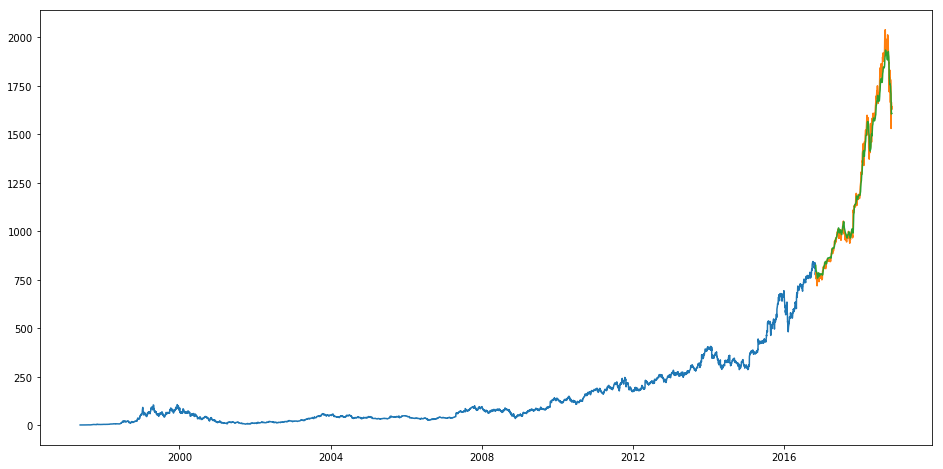

In [31]:
#for plotting
train = new_data[:4898]
valid = new_data[4898:]
valid['Predictions'] = closing_price
plt.figure(figsize=(16,8))
plt.plot(train['close'])
plt.plot(valid[['close','Predictions']])

## Inference

Wow! LSTM has easily outshone any algorithm we saw so far. The LSTM model can be tuned for various parameters such as changing the number of LSTM layers, adding dropout value or increasing the number of epochs. But are the predictions from LSTM enough to identify whether the stock price will increase or decrease? Certainly not!

As I mentioned at the start of the article, stock price is affected by the news about the company and other factors like demonetization or merger/demerger of the companies. There are certain intangible factors as well which can often be impossible to predict beforehand.